**Imports**

Data

In [3]:
import pandas as pd
import os
print(os.getcwd())
current_folder = os.getcwd()
CDs_folder = '../CDs_and_Vinyl'

# Open and load json training files
x = pd.read_json(os.path.join(current_folder, CDs_folder, 'train', 'review_training.json'))
y = pd.read_json(os.path.join(current_folder, CDs_folder, 'train', 'product_training.json'))

/Users/maxrogal/Desktop/Machine Learning/amazonawesomeness


Other

In [4]:
import numpy as np
from nltk import sentiment
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import cross_validate
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [22]:
x

,asin,reviewerID,unixReviewTime,vote,verified,reviewTime,style,reviewerName,reviewText,summary,image
0,6673F1740E03573BCD64238FE711FC69,9C856D4A18E1355783B3B28B7ECC1848,1451520000,9,True,"12 31, 2015",{'Format:': ' MP3 Music'},8D88BB79AAC50277AEE82FCFD77F6744,Finding the Beatles all over again - and bette...,I sit listening - with my jaw to the floor - H...,None
1,690819436E20BB31657AF6B58B984DD4,6E9ABBD26A27C2B2851D1EC34A01CBDC,1113523200,9,False,"04 15, 2005",{'Format:': ' Audio CD'},8DC0611245A871AC51BBEEBB85F33A58,These guys can sing! Such classic tunes...poi...,Under Appreciated....,None
2,A680D4753F0CEA2252C168A6ACB2B623,B637C3C93E61094474710F456928BE9F,1126137600,None,False,"09 8, 2005",None,2259386624CFA0EC53A75A50A9BB57A5,"Snoop Doggy Dogg made a classic album, DoggySt...",DoggyStyle,None
3,F4A966F1FA340B16651D676BC246D227,AA7918E9410D650A076221C7B2934A09,954979200,None,False,"04 6, 2000",{'Format:': ' Audio CD'},7A65A155C993535BC99CBCB39E7161B5,Stevie Nicks Has had Her Moments. I Like Some ...,Pretty Good but a Bit Dated,None
4,EF59DAF0C00319A48D4784266FD157EE,2293C9B7950A3356B95828419A677720,1477958400,None,True,"11 1, 2016",{'Format:': ' Audio CD'},C69A09446009C500B1364B7DB5510497,Great cd.,Five Stars,None
...,...,...,...,...,...,...,...,...,...,...,...
770781,BD91503308A437374C3254EDC8BC24CB,936ED23AF4D23943786BBD44D0F1114B,1136246400,12,True,"01 3, 2006",{'Format:': ' Audio CD'},AAB61000438939C8E6165CFCCF02A488,This was the first Simple Minds album that I b...,Their Most Fully Realized Artistic Studio Stat...,None
770782,9BC50277D18FAB423AD33C8CE4CC000D,EF922377A87E9D01F50065F2DA1722A8,1290556800,None,False,"11 24, 2010",None,0441BC4F6B7BD180769FDCDD8E603560,I have owned a CD copy of this show for at lea...,Forgettable R&H,None
770783,4062627CA1586E517520483964299349,E1F0B0EBC6A36F33301E4FD0B3D62D52,1311120000,3,False,"07 20, 2011",{'Format:': ' Audio CD'},8AB3EEBF23F3583A4396A57DB291D548,carnival of souls to me is bad i gave my cd aw...,Darren d.,None
770784,0AE44A6A9176E6A52507B6ABDDA80B00,DDDC81E6B8C3F8C91867F9AECB385135,1111968000,2,False,"03 28, 2005",{'Format:': ' Audio CD'},51B2E62E0A5864316BDB33FD4A729B37,This is an awesome slayer album. I love the th...,awesome slayer cd,None


PATCH TO SPEED UP (ONLY IF INTEL CHIP) 

In [5]:
from sklearnex import patch_sklearn 

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Pre Processing

In [ ]:
x #770786 rows <- # reviews
y #073082 rows <- # products

# Feature creation 

Making a sample set to test features:

In [ ]:
#ts = test sample 2 thousand reviews long
ts = x[:2000]
ts

Review Count

In [6]:
dropUnverified = x[x.verified == True]
reviewCount = x.groupby('asin')["reviewerID"].count()
reviewCount = reviewCount.rename("Review_Count")

In [7]:
dropUnverified.groupby('asin')['unixReviewTime'].mean() #63401 rows! -> some products don't have ANY verified reviews

asin
0000B049F5B33CD310EB1AB236E20191    1.419682e+09
00018184A9EC4D270219A296B2580303    1.445414e+09
000281A9CAC43FF1F335726A390636DA    1.326499e+09
00030884DF109F325638A6BFD5B13CFF    1.397896e+09
000325BA25966B5FC701D5D2B5DBA4E0    1.363802e+09
                                        ...     
FFFDD3C72D23AF858D6E0ED92612370D    1.406650e+09
FFFDDE284A73B29B320381487EC7DE9E    1.401192e+09
FFFEB3EE2372807964F024707D50FB21    1.349050e+09
FFFF4545AB232D81D0F9B208388BB7AA    1.434283e+09
FFFF5A3D9CB0B40FF0FE6B95F05D26FE    1.498781e+09
Name: unixReviewTime, Length: 63401, dtype: float64

Percent verified

In [8]:
percent_verified = dropUnverified.groupby("asin")["reviewerID"].count()
percent_verified = percent_verified/reviewCount
percent_verified = percent_verified.apply(lambda x: x if x > 0  else 0)
percent_verified = percent_verified.rename("%_Verified")

Dropping bots by time of post

All the comments are encoded with the date only, no time, so this is not possible

In [9]:
droppedBots = x[x.unixReviewTime % 100 != 0]

Total number of votes across reviews

In [10]:
x_copy = x.copy(deep=True)
total_review_num = x_copy.vote
total_review_num = total_review_num.apply(lambda x: float(x.replace(",", "")) if type(x) == str  else 0)
total_review_num = total_review_num.rename("vote").to_frame()
x_copy["vote"] = total_review_num["vote"]
total_votes = x_copy.groupby('asin')["vote"].sum("vote")
total_votes = total_votes.rename("Total_Votes")

Percent of reviews with images

In [11]:
with_image = x[x.image.astype('string') != "None"]
with_image = with_image.groupby('asin')["image"].count()
with_image_percentage = with_image/reviewCount
with_image_percentage = with_image_percentage.apply(lambda x: x if x > 0  else 0)
#with_image_percentage = with_image_percentage[with_image_percentage > 0] # - to see how many reviews have at least one image
with_image_percentage = with_image_percentage.rename("%_Image")

# Text Analysis

Small group to test text analyses

In [ ]:
testdata = x.groupby("asin").get_group("0000B049F5B33CD310EB1AB236E20191")

# np.mean(len(str(testdata["reviewText"]).split()))

Length of Reviews Feature

In [12]:
reviewlength = x.groupby('asin')["reviewText"].apply(lambda x: x.str.split().str.len().mean())
reviewlength = reviewlength.fillna(0).rename("Review_Length")

summarylength = x.groupby('asin')["summary"].apply(lambda x: x.str.split().str.len().mean())
summarylength = summarylength.fillna(0).rename("Summary_Length")


In [ ]:
a= 1

def f(votes):
    if (votes>a):
        return 2
    return 344

In [19]:
# x=x[:200]
# sia = sentiment.SentimentIntensityAnalyzer()
# RSentiment = x["reviewText"].apply(lambda x: sia.polarity_scores(x.to_string())["compound"]) #sentiment per no avg
# RSentiment = RSentiment.fillna(0).rename("Review_sentiment") #make that col
# #apply f(votes) to each element
# #avg the result



AttributeError: 'str' object has no attribute 'to_string'

Percentage Uppercase Feature:

In [13]:
# def count_cap(str):
#     stripped = ''.join(str.split())
#     return sum(c.isupper() for c in ''.join(stripped))/len(stripped)

RpercentCap = x.groupby('asin')["reviewText"].apply(lambda x: (x.str.count("[A-Z]")/x.str.len()).mean())
RpercentCap = RpercentCap.fillna(0).rename("Review_Percent_Uppercase")

SpercentCap = x.groupby('asin')["summary"].apply(lambda x: (x.str.count("[A-Z]")/x.str.len()).mean())
SpercentCap = SpercentCap.fillna(0).rename("Summary_Percent_Uppercase")


Actual Awesomeness Feature: # times the word "awesome" is used per review

In [14]:
actualAwesomeness = x.groupby('asin')["reviewText"].apply(lambda x: (x.str.count("[Aa]wesome")).mean())
actualAwesomeness = actualAwesomeness.fillna(0).rename("Actual_Awesomeness")

In [110]:
actualAwesomeness

asin
0000B049F5B33CD310EB1AB236E20191    0.000000
00018184A9EC4D270219A296B2580303    0.055556
000281A9CAC43FF1F335726A390636DA    0.000000
00030884DF109F325638A6BFD5B13CFF    0.068966
000325BA25966B5FC701D5D2B5DBA4E0    0.500000
                                      ...   
FFFDD3C72D23AF858D6E0ED92612370D    0.125000
FFFDDE284A73B29B320381487EC7DE9E    0.000000
FFFEB3EE2372807964F024707D50FB21    0.000000
FFFF4545AB232D81D0F9B208388BB7AA    0.000000
FFFF5A3D9CB0B40FF0FE6B95F05D26FE    0.185185
Name: Actual_Awesomeness, Length: 73082, dtype: float64

# Sentiment Analysis

In [15]:
## Helper function for sentiment analysis testing
def review_sentiment(text):
    sia = sentiment.SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)["compound"]

## just some examples to gut check
# print(review_sentiment("Ugh, what a terrible, horrible, no good, very bad day"))
# print(review_sentiment("I went to the store today"))
# print(review_sentiment("I absolutely love my favorite best friend"))

import string
def preprocess(text):
    try:
        lemmatizer = WordNetLemmatizer()
        text = "".join([char for char in text.lower() if char not in string.punctuation])
        words = [word for word in word_tokenize(text) if word not in stopwords.words("english")]
        tokens = [lemmatizer.lemmatize(token) for token in words]
        return ' '.join(tokens)
    except:
        return ""

preprocess

In [ ]:
x["processedTest"] = x["reviewText"].apply(preprocess)
x["processedTest"].to_json("../processedReviews.json")
x["processedSums"] = x["summary"].apply(preprocess)
x["processedSums"].to_json("../processedSummary.json")

Read from the jsons

In [117]:
revtext = pd.read_json("../processedReviews.json",typ='series')
revtext.to_frame('processedText')
x["processedText"] = revtext.fillna("")

sumtext = pd.read_json("../processedReviews.json",typ='series')
sumtext.to_frame('processedText')
x["processedSums"] = sumtext.fillna("")

In [118]:
ts = x[:2000]
ts

,asin,reviewerID,unixReviewTime,vote,verified,reviewTime,style,reviewerName,reviewText,summary,image,processedText,processedSums
0,6673F1740E03573BCD64238FE711FC69,9C856D4A18E1355783B3B28B7ECC1848,1451520000,9,True,"12 31, 2015",{'Format:': ' MP3 Music'},8D88BB79AAC50277AEE82FCFD77F6744,Finding the Beatles all over again - and bette...,I sit listening - with my jaw to the floor - H...,None,finding beatles better ever im huge beatles fa...,finding beatles better ever im huge beatles fa...
1,690819436E20BB31657AF6B58B984DD4,6E9ABBD26A27C2B2851D1EC34A01CBDC,1113523200,9,False,"04 15, 2005",{'Format:': ' Audio CD'},8DC0611245A871AC51BBEEBB85F33A58,These guys can sing! Such classic tunes...poi...,Under Appreciated....,None,guys sing classic tunespoignant painful heartf...,guys sing classic tunespoignant painful heartf...
2,A680D4753F0CEA2252C168A6ACB2B623,B637C3C93E61094474710F456928BE9F,1126137600,None,False,"09 8, 2005",None,2259386624CFA0EC53A75A50A9BB57A5,"Snoop Doggy Dogg made a classic album, DoggySt...",DoggyStyle,None,snoop doggy dogg made classic album doggystyle...,snoop doggy dogg made classic album doggystyle...
3,F4A966F1FA340B16651D676BC246D227,AA7918E9410D650A076221C7B2934A09,954979200,None,False,"04 6, 2000",{'Format:': ' Audio CD'},7A65A155C993535BC99CBCB39E7161B5,Stevie Nicks Has had Her Moments. I Like Some ...,Pretty Good but a Bit Dated,None,stevie nicks moments like solo work love fleet...,stevie nicks moments like solo work love fleet...
4,EF59DAF0C00319A48D4784266FD157EE,2293C9B7950A3356B95828419A677720,1477958400,None,True,"11 1, 2016",{'Format:': ' Audio CD'},C69A09446009C500B1364B7DB5510497,Great cd.,Five Stars,None,great cd,great cd
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,14673A3D627445E270EBD9D11D2F70DD,9C84E3EFF58B759FE040B8938E6BD3DE,1460764800,None,True,"04 16, 2016",{'Format:': ' Audio CD'},1BBF7C11163C6DC130DD1EE87152CFD9,Same review as Vol. 1: Super jamming! Inspir...,Super jamming! Inspired me to get my guitar ou...,None,review vol 1 super jamming inspired get guitar...,review vol 1 super jamming inspired get guitar...
1996,35A0CA6AE8C14595607D38DAC6525752,3ED9CD1EC55F0D896F93DA465C4712A9,1420243200,3,True,"01 3, 2015",{'Format:': ' Audio CD'},17AD55A9B8384777496330D23E59D520,"WONDERFUL PURCHASE, ""Linda Rondstadt: The Coll...","WONDERFUL PURCHASE, ""Linda Rondstadt",None,wonderful purchase linda rondstadt collection ...,wonderful purchase linda rondstadt collection ...
1997,1C2F7451F06F0C2958694833095CB947,BA489C468556F643565413143979D571,1388966400,None,True,"01 6, 2014",{'Format:': ' Audio CD'},429889A95D8338A1312654487D673DAA,THIS MUSIC IS NICE. I MEAN WHAT MORE CAN I SAY...,NICE MUSIC,None,music nice mean say everything comes quality vibe,music nice mean say everything comes quality vibe
1998,C3D898B23687DE2EBB9350FE17F8CD24,FCF6C84C748B7E345693A45636118FAB,1127174400,10,False,"09 20, 2005",{'Format:': ' Audio CD'},3EA8FAFD8BB387929FBB53DDF4C8DAF9,I loved listening to the music of Barbara Str...,Barbara and Barry make musical magic together,None,loved listening music barbara streisand barry ...,loved listening music barbara streisand barry ...


Apply sentiment analysis to data

In [131]:
sia = sentiment.SentimentIntensityAnalyzer()
ts["sumsent"] = ts["processedSums"].apply(lambda x: sia.polarity_scores(x)["compound"])
ts.groupby("asin").mean()["sumsent"]
# Rtest = Rtest.rename("Review_Avg_Sentiment")

# Stest = x.groupby('asin')["processedSums"].fillna("").apply(lambda x: np.mean(sia.polarity_scores(x)["compound"]))
# Stest = Stest.rename("Summary_Avg_Sentiment")

/var/folders/9p/sh_j3mrj2z374f2jzhy0z5mm0000gn/T/ipykernel_23720/2077047471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts["sumsent"] = ts["processedSums"].apply(lambda x: sia.polarity_scores(x)["compound"])


asin
001D103D75A5694360941BEC51CEDAAA    0.8176
002A2BBBB4571D357775F637CCCEB524    0.9062
002DBFFDFE2E1C6C0BF01EB3BD2FD240    0.5719
00734D25B89256B1F28189D85DC69DAA    0.8883
0075BB016BA9DDD97B73646837308B55    0.9600
                                     ...  
FF842E4E26D4CC326384241595AF6C7C    0.8481
FF879042885BA878431BED1BEA88DE5E    0.9709
FF958322E74B2D83CEEA505960262354    0.9943
FFA4EF1D77F95F89DE59138D51BC29C2    0.5271
FFF6441225687D6E53F1C7962666D5D0    0.5719
Name: sumsent, Length: 1847, dtype: float64

In [132]:
sia = sentiment.SentimentIntensityAnalyzer()
x["rsent"] = x["processedText"].apply(lambda x: np.mean(sia.polarity_scores(x)["compound"]))
RavgSentiment = x.groupby("asin").mean()["rsent"]
RavgSentiment = RavgSentiment.rename("Review_Avg_Sentiment")


sia = sentiment.SentimentIntensityAnalyzer()
x['sumsent'] = x["processedSums"].apply(lambda x: np.mean(sia.polarity_scores(x)["compound"]))
SavgSentiment = x.groupby("asin").mean()["sumsent"]
SavgSentiment = SavgSentiment.rename("Summary_Avg_Sentiment")


In [133]:
RavgSentiment

asin
0000B049F5B33CD310EB1AB236E20191    0.880950
00018184A9EC4D270219A296B2580303    0.647539
000281A9CAC43FF1F335726A390636DA    0.688850
00030884DF109F325638A6BFD5B13CFF    0.622297
000325BA25966B5FC701D5D2B5DBA4E0    0.768700
                                      ...   
FFFDD3C72D23AF858D6E0ED92612370D    0.606214
FFFDDE284A73B29B320381487EC7DE9E    0.955075
FFFEB3EE2372807964F024707D50FB21    0.961100
FFFF4545AB232D81D0F9B208388BB7AA    0.691300
FFFF5A3D9CB0B40FF0FE6B95F05D26FE    0.322115
Name: Review_Avg_Sentiment, Length: 73082, dtype: float64

# tfidf

In [71]:
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=10)
# 
# x["processedText"] = revtext
tfidf_DF = x[["asin","processedText"]]



# tfidf_DF["processedText"] = 
# tfidf_DF["processedTest"] = tfidf_DF["processedTest"].fillna("")
# tfidf_DF["processedRevs"] = tfidf_DF["reviewText"].fillna("").apply(preprocess)

tfidf.fit_transform(tfidf_DF["processedText"])
# tfidffeatures.toarray()
feature_names = tfidf.get_feature_names()
tfidfarray = tfidf.transform(tfidf_DF["processedText"]).toarray()

featuredf = pd.DataFrame(tfidfarray,columns = feature_names)
tfidf_DF = pd.concat([tfidf_DF,featuredf],axis=1)
tfidfFeature = tfidf_DF.groupby("asin")[feature_names].mean()

tfidfFeature


,album,cd,good,great,like,love,music,one,song,songs
asin,,,,,,,,,,
0000B049F5B33CD310EB1AB236E20191,0.103945,0.357921,0.140438,0.000000,0.047707,0.650598,0.146021,0.092346,0.000000,0.070214
00018184A9EC4D270219A296B2580303,0.078173,0.383805,0.097147,0.164038,0.186362,0.198336,0.165989,0.311123,0.059100,0.083888
000281A9CAC43FF1F335726A390636DA,0.287603,0.000000,0.172802,0.250000,0.317977,0.000000,0.078973,0.153875,0.000000,0.000000
00030884DF109F325638A6BFD5B13CFF,0.172072,0.112765,0.062137,0.128254,0.151698,0.198789,0.117097,0.182168,0.009765,0.086507
000325BA25966B5FC701D5D2B5DBA4E0,0.122886,0.364342,0.000000,0.168699,0.135864,0.250000,0.138615,0.098620,0.000000,0.173658
...,...,...,...,...,...,...,...,...,...,...
FFFDD3C72D23AF858D6E0ED92612370D,0.437644,0.062684,0.132988,0.182225,0.103807,0.040482,0.042317,0.125199,0.157424,0.217296
FFFDDE284A73B29B320381487EC7DE9E,0.000000,0.160313,0.161066,0.133889,0.093727,0.289807,0.261508,0.511966,0.000000,0.000000
FFFEB3EE2372807964F024707D50FB21,0.338402,0.000000,0.392162,0.178449,0.000000,0.220705,0.374920,0.174604,0.224379,0.000000


# Testing prep

Feature vectors must have format: col 1 as 'asin'

Currently using features:

Name                    |     Column Name

reviewCount                    Review_Count

~~with_image_percentage          %_Image~~

percent_verified               %_Verified

total_votes                    Total_Votes

reviewlength                   Review_Length

summarylength                  Summary_Length

RpercentCap                    Review_%_Uppercase

SpercentCap                    Summary_%_Uppercase

~~actualAwesomeness              Actual_Awesomeness~~

RavgSentiment                  Review_Avg_Sentiment

SavgSentiment                  Summary_Avg_Sentiment

In [134]:
#combine all individual features into one dataFrame

#enter any features to be combined here! 
#   They must be pd dataFrames with the 'asin' column for this to work
features = [reviewCount,percent_verified,total_votes,reviewlength,summarylength,RpercentCap,SpercentCap,RavgSentiment,SavgSentiment]

z = x['asin']
for f in features:
    z = pd.merge(z,f,'inner','asin')

for i in range(tfidfFeature.shape[1]):
    z = pd.merge(z,tfidfFeature[feature_names[i]],'inner','asin')



#combine resultant data with correct answers 
temp = pd.merge(z,y,'inner','asin') 
temp = temp.groupby("asin").mean()


#split into features (x) and awesomeness (y), which now row correspond
merged_x = temp.drop(['awesomeness'], axis=1)
merged_y = temp["awesomeness"]

In [74]:
merged_x[:10]

,Review_Count,%_Verified,Total_Votes,Review_Length,Summary_Length,Review_Percent_Uppercase,Summary_Percent_Uppercase,album,cd,good,great,like,love,music,one,song,songs
asin,,,,,,,,,,,,,,,,,
0000B049F5B33CD310EB1AB236E20191,4.0,0.500000,6.0,88.500000,4.500000,0.210796,0.503689,0.103945,0.357921,0.140438,0.000000,0.047707,0.650598,0.146021,0.092346,0.000000,0.070214
00018184A9EC4D270219A296B2580303,18.0,0.166667,45.0,235.222222,5.166667,0.076743,0.115941,0.078173,0.383805,0.097147,0.164038,0.186362,0.198336,0.165989,0.311123,0.059100,0.083888
000281A9CAC43FF1F335726A390636DA,4.0,0.750000,5.0,130.500000,3.500000,0.086681,0.153030,0.287603,0.000000,0.172802,0.250000,0.317977,0.000000,0.078973,0.153875,0.000000,0.000000
00030884DF109F325638A6BFD5B13CFF,29.0,0.586207,83.0,79.655172,5.000000,0.059310,0.121813,0.172072,0.112765,0.062137,0.128254,0.151698,0.198789,0.117097,0.182168,0.009765,0.086507
000325BA25966B5FC701D5D2B5DBA4E0,4.0,1.000000,7.0,91.500000,3.000000,0.038202,0.124301,0.122886,0.364342,0.000000,0.168699,0.135864,0.250000,0.138615,0.098620,0.000000,0.173658
00039B53F332D3A911B0B18F88051C80,6.0,0.666667,27.0,155.666667,4.833333,0.040205,0.102725,0.048509,0.058020,0.101119,0.164452,0.094307,0.174538,0.116126,0.257909,0.176273,0.388966
000449E7E71585B3F1A7EAE8B654B468,2.0,0.000000,30.0,160.000000,6.000000,0.011419,0.022222,0.221055,0.000000,0.000000,0.241748,0.730377,0.144171,0.249351,0.117587,0.000000,0.000000
0004D01A4CED3FE007D35FB3933B3A6C,5.0,0.400000,29.0,347.000000,5.800000,0.036524,0.053700,0.503891,0.000000,0.000000,0.162743,0.385328,0.127109,0.239781,0.165035,0.099658,0.260891
00055F6EC779D818B9F33AA0885FC6E3,4.0,0.750000,24.0,160.500000,11.500000,0.061778,0.090441,0.236570,0.146833,0.147524,0.138489,0.081031,0.558581,0.138480,0.117637,0.097191,0.000000


# Models

(choose one)

Support Vector Machine (SVM)

In [75]:
from sklearn import svm

#kernel type
#‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
kernel = 'poly'

#if kernel type = 'poly', degree of poly
degree = 4

#whether to enable probability estimates (will slow it down a lot)
probability = False

#tau - penalty for errors is inversely proportional to C
C = 0.75

param_grid = [{'kernel': ['poly','rbf','sigmoid'],
             'C': [0.25,0.5,0.75,1]}]

# param_grid = [{'kernel': ['poly','rbf','sigmoid'],
#             'C': [0.25,0.5,0.75,1]}]
# -> {'C': 0.75, 'kernel': 'poly'}
# f1: 0.694757392846268

# param_grid = [{'degree': [2,3,4,5],
#              'C': [0.7,0.75,0.8]}]
# -> {'C': 0.75, 'degree': 4}
# f1: 0.6805724352995487

svm_model = svm.SVC(C=C, kernel=kernel, degree=degree, probability=probability)

Basic Gaussian Naive Bayes

In [76]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

Decision Tree

In [77]:
from sklearn import tree

#choose from 'entropy', 'gini', 'log_loss'
criterion = 'gini'

    ###STOPPING CONDITIONS
#max height/depth of the tree OR None if no limit
max_depth = 5

#if sat(N) < n_samples*this, don't try to split it any further
min_samples_split = .05

    ###OTHER
#if min(sat(nodes after a split)) < n_samples*this, split not considered 
#       (aka model isnt allowed to create leaf nodes with < n_samples*this samples)
#       (smooths the model, avoids splits like 2000 -> 1999 vs 1)
min_samples_leaf = 0.01

# param_grid = [{'criterion': ['entropy','gini','log_loss'],
#             'max_depth': [None,5,10,15,20],
#             'min_samples_split': [2,10,20,0.01,0.05,0.1,0.2],
#             'min_samples_leaf':[2,10,20,0.01,0.05,0.1,0.2]}]
# -> {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 0.01, 'min_samples_split': 0.05}
# f1: 0.6440347415923986

dtree_model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

Decision Tree - See what it looks like! 

(only run if the model is a decision tree)

*note: this trains the model on the whole dataset, so don't do before testing!*

[Text(131.52857142857144, 199.32, 'X[11] <= 0.129\ngini = 0.498\nsamples = 73082\nvalue = [34205, 38877]'),
 Text(52.611428571428576, 163.07999999999998, 'X[1] <= 0.041\ngini = 0.487\nsamples = 39315\nvalue = [16481, 22834]'),
 Text(19.13142857142857, 126.83999999999999, 'X[0] <= 2.5\ngini = 0.493\nsamples = 3997\nvalue = [2231, 1766]'),
 Text(9.565714285714286, 90.6, 'gini = 0.5\nsamples = 2147\nvalue = [1085, 1062]'),
 Text(28.697142857142858, 90.6, 'gini = 0.471\nsamples = 1850\nvalue = [1146, 704]'),
 Text(86.09142857142857, 126.83999999999999, 'X[9] <= 0.142\ngini = 0.481\nsamples = 35318\nvalue = [14250, 21068]'),
 Text(47.82857142857143, 90.6, 'X[12] <= 0.053\ngini = 0.467\nsamples = 22903\nvalue = [8494, 14409]'),
 Text(28.697142857142858, 54.359999999999985, 'X[10] <= 0.221\ngini = 0.48\nsamples = 9373\nvalue = [3754, 5619]'),
 Text(19.13142857142857, 18.119999999999976, 'gini = 0.488\nsamples = 5812\nvalue = [2462, 3350]'),
 Text(38.26285714285714, 18.119999999999976, 'gini =

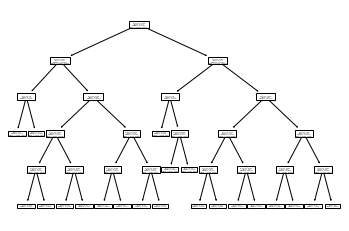

In [59]:
dtree_model.fit(merged_x,merged_y)
tree.plot_tree(dtree_model)

K-Nearest Neighbors

In [78]:
from sklearn.neighbors import KNeighborsClassifier

#number of neighbors
n_neighbors = 2500

#do you want proximity to effect influence neighbors have or not
# 'uniform' or 'distance'
weights='distance'

#leaf size passed to trees
leaf_size=3

# param_grid = [{'n_neighbors': [5,7,9,11],
#             'weights': ['uniform','distance'],
#             'leaf_size':[15,20,25,30]}] -> f1: 0.67, {'leaf_size': 15, 'n_neighbors': 11, 'weights': 'uniform'}

# param_grid = [{'n_neighbors': [9,11,15,19,23],
#              'weights': ['uniform','distance'],
#              'leaf_size':[5,10,15,20]}] -> f1: 0.65, {'leaf_size': 5, 'n_neighbors': 23, 'weights': 'uniform'}

# param_grid = [{'n_neighbors': [11,22,33,44,55],
#              'weights': ['uniform','distance'],
#              'leaf_size':[1,2,3,4,5,6,7,8,9,10,11,12]}] 
# -> {'leaf_size': 1, 'n_neighbors': 55, 'weights': 'uniform'}
# f1: 0.63

# param_grid = [{'n_neighbors': [11,22,33,44,55],
#              'weights': ['uniform','distance'],
#              'leaf_size':[1,2,3,4,5,6,7,8,9,10,11,12]}]
# -> {'leaf_size': 3, 'n_neighbors': 55, 'weights': 'distance'}
# f1: 0.6115

# param_grid = [{'n_neighbors': [1000,1500,2000,2500]}]
# -> {'n_neighbors': 2500}

knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, leaf_size=leaf_size, n_jobs=-1)

Logistic Regression

In [79]:
from sklearn.linear_model import LogisticRegression

#norm of the penalty
#‘l1’, ‘l2’, ‘elasticnet’, None
penalty = 'l2'

#inverse of regulation strength tau - how much do errors cost?
C = 0.35

#algorithm to compute optimization problem. Probs wont do much other than speed
#‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’
solver = 'sag'

max_iter=500

# param_grid = [{'penalty': ['l1','l2','elasticnet',None],
#             'C': [0.25,0.5,0.75,1],
#             'solver': ['lbfgs','newton-cg','newton-cholesky','sag','saga'],
#             'max_iter': [1000,500,100]}]        
# -> {'C': 0.5, 'max_iter': 500, 'penalty': 'l2', 'solver': 'sag'}
# f1: 0.6916044272473679

# param_grid = [{'C': [0.4,0.45,0.5,0.55,0.6],
#             'solver': ['lbfgs','newton-cg','newton-cholesky','sag','saga'],
#             'max_iter': [700,600,500,400,300]}]
# -> {'C': 0.4, 'max_iter': 500, 'solver': 'sag'}
# f1: 0.6915982039214981

# param_grid = [{'C': [0.3,0.35,0.4,0.45]}]
# -> {'C': 0.35}
# f1: 0.6915982039214981

regression_model = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=max_iter, n_jobs=-1)

Try nonlinear regression by manipulating given features:

In [80]:
#to nonlinearly transform features!
#np.sqrt, np.log, np.square
f = np.sqrt

merged_x = merged_x.apply(lambda x: f(x+1))

Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

#number of trees, int
n_estimators=150

#Criteria to determine split quality
#“gini”, “entropy”, “log_loss”
criterion = 'log_loss'

#max depth of each tree, int or None for infinite
max_depth = None

#min #/% of samples to leave in a branch after a split
min_samples_split = 0.25

#min #/% of samples to be a leaf node
min_samples_leaf = 0.4

# param_grid = [{'n_estimators': [50,100,150],
#             'criterion': ['gini','entropy','log_loss'],
#             'max_depth':[None,10,15,20],
#             'min_samples_split':[2,0.01,0.05,0.1,0.2],
#             'min_samples_leaf':[2,0.01,0.05,0.1,0.2]}]
# -> {'criterion': 'log_loss', 'max_depth': None, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'n_estimators': 150}
# f1: 0.686935866983373

# param_grid = [{'n_estimators': [125,150,175,200],
#             'min_samples_split':[.1,.2,.3],
#             'min_samples_leaf':[.1,.2,.3]}]
# -> {'min_samples_leaf': 0.3, 'min_samples_split': 0.2, 'n_estimators': 150}
# f1: 0.6944863744763707
            
# param_grid = [{'n_estimators': [140,145,150,155,160],
#             'min_samples_split':[.15,.2,.25],
#             'min_samples_leaf':[.25,.3,.35,.4]}]
# -> {'min_samples_leaf': 0.4, 'min_samples_split': 0.25, 'n_estimators': 150}
# f1: 0.6944863744763707

# param_grid = [{'min_samples_split':[0.15,0.175,0.2,0.225,0.25,0.275,0.3]}]
# -> 0.6944863744763707
# {'min_samples_split': 0.25}

randomforest_model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, n_jobs=-1)

# Boosting!
make a model better! goes into *boosted_model*

AdaBoost

In [82]:
from sklearn.ensemble import AdaBoostClassifier

#model to build off of
#estimator = model

#max number of estimators to compute before terminating testing
n_estimators = 20

#weight applied to each classifier at each boosting iteration
learning_rate = 1.0

# param_grid = [{'n_estimators': [10,20,30],
#             'learning_rate': [1,2,3]}]

adaboosted_model = AdaBoostClassifier(estimator=regression_model, n_estimators=n_estimators, learning_rate=learning_rate)

TypeError: __init__() got an unexpected keyword argument 'estimator'

Gradient Boosting

In [83]:
from sklearn.ensemble import HistGradientBoostingClassifier

#loss function to use in boosting process
#‘log_loss’, ‘auto’, ‘binary_crossentropy’/depreciated, ‘categorical_crossentropy’
loss = 'log_loss'

#shrinkage - multiplicative value for leaves
learning_rate=0.24

#maximum iterations for boosting process
max_iter=1

#maximum leaf nodes/tree
max_leaf_nodes=2

#max depth/tree or None for infinite
max_depth = None

#min samples to be a leaf
min_samples_leaf=15

#regularization parameter, 0 for none
l2_regularization=0

# param_grid = [{'learning_rate': [0.1,0.3,0.5,0.7,1],
#             'max_iter':[50,60],
#             'max_leaf_nodes':[25,30,35,40],
#             'max_depth':[None,10,15,20],
#             'min_samples_leaf':[20,0.01,0.05,0.1,0.2],
#             'l2_regularization':[0,0.1,0.2]}] 
# -> f1: 0.67, {'l2_regularization': 0, 'learning_rate': 0.3, 'max_depth': None, 'max_iter': 50, 'max_leaf_nodes': 25, 'min_samples_leaf': 20}

# param_grid = [{'learning_rate': [0.2,0.25,0.3,0.35,0.4],
#             'max_iter':[30,40,50],
#             'max_leaf_nodes':[10,15,20,25],
#             'min_samples_leaf':[10,15,20,25,30]}] 
# -> f1: 0.66 {'learning_rate': 0.3, 'max_iter': 30, 'max_leaf_nodes': 10, 'min_samples_leaf': 15}

# param_grid = [{'learning_rate': [0.25,0.275,0.3,0.325,0.35],
#             'max_iter':[1,10,20,30],
#             'max_leaf_nodes':[2,4,6,8,10],
#             'min_samples_leaf':[12,13,14,15,16,17,18]}] 
# -> f1: 0.68 {'learning_rate': 0.275, 'max_iter': 1, 'max_leaf_nodes': 4, 'min_samples_leaf': 14}

# param_grid = [{'learning_rate': [0.265,0.27,0.275,0.28,0.285],
#             'max_leaf_nodes':[2,3,4,5,6],
#             'min_samples_leaf':[13,14,15]}] 
# -> f1: 0.68 {'learning_rate': 0.27, 'max_leaf_nodes': 3, 'min_samples_leaf': 15}

# param_grid = [{'learning_rate': [0.26,0.2665,0.267,0.2675,0.268,0.2685,0.269,0.2695,0.27,0.2705,0.271,0.2715,0.272,0.2725],
#              'max_leaf_nodes':[2,3,4],
#              'min_samples_leaf':[13,14,15,16,17],
#              'max_iter':[0,1,2,3,4,5,6,7,8,9,10]}] 
# -> f1: 0.684 {'learning_rate': 0.269, 'max_iter': 3, 'max_leaf_nodes': 2, 'min_samples_leaf': 16}

# param_grid = [{'learning_rate': [0.26,0.2665,0.267],
#              'max_leaf_nodes':[4,5,6,7,8],
#              'min_samples_leaf':[13,14,15],
#              'max_iter':[3,4,5]}] 
# -> {'learning_rate': 0.26, 'max_iter': 3, 'max_leaf_nodes': 4, 'min_samples_leaf': 15}
# f1: 0.6831502199369314

# param_grid = [{'learning_rate': [0.24,0.245,0.25,0.255,0.26],
#              'max_leaf_nodes':[1,2,3,4,5],
#              'min_samples_leaf':[15,16,17,18],
#              'max_iter':[1,2,3,4]}] 
# -> {'learning_rate': 0.24, 'max_iter': 1, 'max_leaf_nodes': 2, 'min_samples_leaf': 15}
# f1: 0.694

gradient_boosted_model = HistGradientBoostingClassifier(loss=loss, learning_rate=learning_rate, max_iter=max_iter, max_leaf_nodes=max_leaf_nodes, max_depth=max_depth, min_samples_leaf=min_samples_leaf, l2_regularization=l2_regularization)

ImportError: cannot import name 'HistGradientBoostingClassifier' from 'sklearn.ensemble' (/Users/maxrogal/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/__init__.py)

Bagging (for speed!)

In [84]:
from sklearn.ensemble import BaggingClassifier

#number of estimators
n_estimators = 10

bagged_model = BaggingClassifier(svm_model, max_features=1/n_estimators, n_estimators=n_estimators, n_jobs=-1)

LATE FUSION

In [85]:
from sklearn.ensemble import StackingClassifier

#which models to use for primary predictions
estimators = [('forest',randomforest_model),('knn',knn_model),('dtree',dtree_model)]

#which model to use for final prediction
final_estimator = svm_model

#k for cross validation for training of final_estimator
cv = 10

late_fused_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator,cv=cv,n_jobs=-1)

Standard scaler pipeline

In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('scaler', StandardScaler()), ('model', knn_model)])

# Testing

COMBINED NODE FOR TESTING AND PRINTING BC IM LAZY

In [87]:
#desired metrics
scoring=['f1','accuracy','precision','recall']

#number of "folds"
k=10

cv_results = cross_validate(randomforest_model, merged_x, merged_y, cv=k, scoring=scoring)

# pretty print results
hline = ("-"*40)

#print means, stdevs
print(hline+"\n\tAVG, STDEV TEST RESULTS\n"+hline)
print("\t\tMEAN\t\tSTDEV")
for m in scoring:
        ind = ("test_"+m)
        test = (m+":").ljust(10)
        print(f"{test}\t{np.round(cv_results[ind].mean(),4)}\t\t{np.round(cv_results[ind].std(),4)}")

/Users/maxrogal/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/maxrogal/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 436, in _process_worker
    r = call_item()
  File "/Users/maxrogal/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 288, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/Users/maxrogal/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "/Users/maxrogal/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/maxrogal/opt/anacon

----------------------------------------
	AVG, STDEV TEST RESULTS
----------------------------------------
		MEAN		STDEV
f1:       	nan		nan
accuracy: 	nan		nan
precision:	nan		nan
recall:   	nan		nan


/Users/maxrogal/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/maxrogal/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 436, in _process_worker
    r = call_item()
  File "/Users/maxrogal/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 288, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/Users/maxrogal/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "/Users/maxrogal/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/maxrogal/opt/anacon

K-Fold testing 

(set model to variable *model*)

In [ ]:
#desired metrics
scoring=['f1','accuracy','precision','recall']

#number of "folds"
k=10

cv_results = cross_validate(model, merged_x, merged_y, cv=k, scoring=scoring)

Pretty print results

In [ ]:
hline = ("-"*40)

#print means, stdevs
print(hline+"\n\tAVG, STDEV TEST RESULTS\n"+hline)
print("\t\tMEAN\t\tSTDEV")
for m in scoring:
        ind = ("test_"+m)
        test = (m+":").ljust(10)
        print(f"{test}\t{np.round(cv_results[ind].mean(),4)}\t\t{np.round(cv_results[ind].std(),4)}")


    ##print per test results (if you really want, uncomment)
# print("\n")
# print(hline+"\n\tPER TEST RESULTS\n"+hline)
# for i in range(k):
#     print(f"Test {i}:")
#     for m in scoring:
#         ind = ("test_"+m)
#         test = (m+":").ljust(10)
#         print(f"\t{test} {np.round(cv_results[ind][i],5)}")

Testing Split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(merged_x, merged_y, test_size=0.5, random_state=2)

Grid Searching for Best Parameters

must have parameters for variable in *params*

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(knn_model, param_grid=param_grid, scoring='f1', cv=10)
grid_search.fit(x_train,y_train)
print(grid_search.best_params_)
print(grid_search.score(x_test,y_test))

Halving random grid search (for speed up)

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

hg_search = HalvingGridSearchCV(knn_model, param_grid=param_grid, scoring='f1', cv=10)
hg_search.fit(x_train,y_train)
print(hg_search.best_params_)
print(hg_search.score(x_test,y_test))

Feature Selection

In [17]:
from sklearn.feature_selection import RFECV

selector = RFECV(randomforest_model, step=1, cv=10) 
selector = selector.fit(merged_x,merged_y)
print(selector.support_)
print(selector.ranking_)
print(selector.feature_names_in_)

[False False False False False False False False  True]
[9 8 7 6 5 4 3 2 1]
['Review_Count' '%_Verified' 'Total_Votes' 'Review_Avg_Sentiment'
 'Summary_Avg_Sentiment' 'Review_Length' 'Summary_Length'
 'Review_Percent_Uppercase' 'Summary_Percent_Uppercase']


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2


print(merged_x.shape)
new_x = SelectKBest(chi2, k='all')
absx = merged_x.apply(lambda x: x+1) #selectKBest requires all positive values, sentiment analysis is between -1 and 1 -> 0 and 2 now!
out = new_x.fit_transform(absx, merged_y)
print(new_x.scores_)
print(new_x.feature_names_in_)
print(out.shape)

# SELECTKBEST: [3.25559172e+02 5.59255454e-03 2.75958219e+01 3.66946669e+02
#  3.42079412e+01 4.36649522e+01 1.85080492e+04 6.30872323e+01
#  7.68359033e-01 3.83305432e-01 1.04268202e-02]
# -['Review_Count' '%_Image' '%_Verified' 'Total_Votes'
#  'Review_Avg_Sentiment' 'Summary_Avg_Sentiment' 'Review_Length'
#  'Summary_Length' 'Summary_Percent_Uppercase' 'Review_Percent_Uppercase'
#  'Actual_Awesomeness']
#-> RFECV: [1 3 1 1 1 1 1 1 1 2]

# SO: 
# Seems like %_image, actual_awesomeness do the least. Percent_uppercases do the next worst.
# -> lets try cutting them out!

#->
# [  325.55917172    27.59582185   366.94666861    34.20794125
#     43.6649522  18508.04915683    63.08723227]
# ['Review_Count' '%_Verified' 'Total_Votes' 'Review_Avg_Sentiment'
#  'Summary_Avg_Sentiment' 'Review_Length' 'Summary_Length']
# -> RFECV2: [4 1 5 1 1 3 2]
#

ROC Curve

In [ ]:
y_pred = randomforest_model.fit(x_train, y_train).predict(x_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
AUROC = metrics.auc(fpr, tpr)

disp = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=AUROC)



fig = plt.figure()
ax = fig.add_subplot()
ax.tick_params(axis='x', colors='white') 
ax.tick_params(axis='y', colors='white') 
ax.spines['left'].set_color('white') 
ax.spines['bottom'].set_color('white') 

plt.rcParams['figure.figsize'] = [10, 10]
plt.xlabel("X",fontsize=20, color='white')
plt.ylabel("Y",fontsize=20, color='white')
plt.title("Area Under ROC Curve", fontsize = 20, color='white')

disp.plot(ax)

plt.show()

# Getting Prediction for Test Data

Loading in test data

In [89]:
x = pd.read_json('CDs_and_Vinyl/test1/review_test.json')
test_y = pd.read_json('CDs_and_Vinyl/test1/product_test.json')

Rerun Variable Analyses! then...

In [ ]:
#Again, combine all individual features into one dataFrame

features = [reviewCount,percent_verified,total_votes,RavgSentiment,SavgSentiment,reviewlength,summarylength,RpercentCap,SpercentCap]

test_merged_x = x['asin']
for f in features:
    test_merged_x = pd.merge(test_merged_x,f,'inner','asin')
test_merged_x = test_merged_x.groupby("asin").mean()

Make prediction

In [93]:
# Make prediction
predictions = randomforest_model.predict(test_merged_x) 

# Rejoin to create output
test_y.insert(1, "predictions", predictions)

In [97]:
test_y = pd.DataFrame(y_test)

Output predictions to file!

In [100]:
# Output predictions to file!
  
#turn predictions into json
json_str = test_y.to_json()

#output json to file
with open('predictions.json', 'w') as f:
    f.write(json_str)